In [1]:
# # 기본 설정 및 라이브러리 임포트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, ttest_ind

# 한글 폰트 설정 (Windows 기준, 다른 OS는 폰트명 변경 필요)
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Seaborn 스타일 설정
sns.set_theme(style="whitegrid", font="Malgun Gothic")

In [2]:
# # 1. 데이터 로딩
# ## 데이터 파일 경로를 사용자의 환경에 맞게 수정해주세요.
# ## 예시: 'data/서울버스 일별 시간대별 승하차 인원.csv'
# ## 원본 노트북의 경로를 그대로 사용하시거나, 현재 노트북 파일과 같은 위치에 데이터를 두고 파일명만 사용하세요.

try:
    # 원본 노트북의 경로를 사용하려면 아래 주석을 해제하고 파일이 있는지 확인하세요.
    # bus_df_raw = pd.read_csv('C:/Users/user/Desktop/데이터/압축푼데이터/서울버스 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    # subway_df_raw = pd.read_csv('C:/Users/user/Desktop/데이터/압축푼데이터/서울철도 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    # weather_df_raw = pd.read_csv('C:/Users/user/Desktop/데이터/압축푼데이터/OBS_ASOS_TIM_20250509144620.csv', encoding='euc-kr') # 파일명으로 보아 2013년 데이터로 추정됩니다. 기간 확인 필수!

    # 아래는 현재 폴더에 파일이 있거나, 'data' 하위 폴더에 있다고 가정하고 파일명만 사용하는 예시입니다.
    # 실제 파일명과 경로로 수정해주세요.
    bus_df_raw = pd.read_csv('서울버스 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    subway_df_raw = pd.read_csv('서울철도 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    weather_df_raw = pd.read_csv('OBS_ASOS_TIM_20250509144620.csv', encoding='euc-kr')


except FileNotFoundError:
    print("오류: 데이터 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    # 예시용 빈 데이터프레임 생성 (오류 방지용)
    bus_df_raw = pd.DataFrame()
    subway_df_raw = pd.DataFrame()
    weather_df_raw = pd.DataFrame()

# 데이터 샘플 확인 (만약 파일 로딩에 성공했다면)
if not bus_df_raw.empty:
    print("--- 버스 데이터 샘플 ---")
    print(bus_df_raw.head())
if not subway_df_raw.empty:
    print("\n--- 지하철 데이터 샘플 ---")
    print(subway_df_raw.head())
if not weather_df_raw.empty:
    print("\n--- 날씨 데이터 샘플 ---")
    print(weather_df_raw.head())

print("\n--- 데이터 로딩 완료 (샘플 데이터가 출력되지 않았다면 파일 경로 확인 필요) ---")

--- 버스 데이터 샘플 ---
         운행일자      노선ID                      노선    정류장ID       정류장  \
0  2014-12-01  11110329          6411번(구로동~개포동)  9009281    신트리아파트   
1  2014-08-15  11110556    7730번(은평공영차고지~이북오도청)  9001990  월곡동두산아파트   
2  2015-06-05  11110677  2312번(중랑공영차고지~강동공영차고지)  8501523    경문고등학교   
3  2015-04-12  11110899     670번(온수동~디지털미디어시티역)  9000198     성내주유소   
4  2015-03-19  11110323    240번(중랑공영차고지~신사역사거리)  9001139    중앙동성당앞   

              승차시간구분  시간구분ID  승차총승객수  하차총승객수  
0  19:00:00~19:59:59      30       6       4  
1  13:00:00~13:59:59       0       6       0  
2  19:00:00~19:59:59      30       1      14  
3  23:00:00~23:59:59       0      19       1  
4  11:00:00~11:59:59      30       1       2  

--- 지하철 데이터 샘플 ---
         운행일자  호선ID   호선   역ID     역             승차시간구분  30분시간구간ID  승차총승객수  \
0  2014-05-21   206  6호선  2626    대흥  21:00:00~21:59:59         30     110   
1  2015-01-15   208  8호선  2826    수진  22:00:00~22:59:59          0      69   
2  2014-07-18   206  6호선 

In [3]:
# # 2. 데이터 전처리

# ## 2.1. 대중교통 데이터 전처리 (버스 + 지하철)
# ### 버스 데이터와 지하철 데이터의 컬럼명이 다를 수 있으므로, 통일하거나 필요한 컬럼만 선택합니다.
# ### 여기서는 원본 노트북의 컬럼명을 기준으로 처리합니다.

def preprocess_transport_data(df, transport_type):
    if df.empty:
        return pd.DataFrame(columns=['날짜', '시간', '총승객수']) # 빈 데이터프레임 반환
        
    temp_df = df.copy()
    # '운행일자' 또는 '사용일자'를 datetime으로 변환
    date_col = '운행일자' if '운행일자' in temp_df.columns else '사용일자'
    temp_df['날짜'] = pd.to_datetime(temp_df[date_col])
    
    # '승차시간구분' 또는 '시간대별'에서 시간(hour) 추출
    # 버스 데이터: '00:00:00~00:59:59' 형식 -> 앞 두 글자 추출
    # 지하철 데이터: '00시-01시' 또는 숫자(0~23) 형식일 수 있음 -> 예시에서는 버스와 유사하다고 가정
    time_col = '승차시간구분' if '승차시간구분' in temp_df.columns else '시간대별' # 지하철 컬럼명 확인 필요
    
    if temp_df[time_col].dtype == 'object': # 문자열 타입인 경우
         temp_df['시간'] = temp_df[time_col].astype(str).str[:2].astype(int)
    else: # 이미 숫자형인 경우 (예: 0, 1, ... 23)
        temp_df['시간'] = temp_df[time_col].astype(int)

    # 승객 수 컬럼 확인 (승차총승객수, 하차총승객수)
    on_col = '승차총승객수' if '승차총승객수' in temp_df.columns else '승차총 인원' # 지하철 컬럼명 확인 필요
    off_col = '하차총승객수' if '하차총승객수' in temp_df.columns else '하차총 인원' # 지하철 컬럼명 확인 필요
    
    temp_df['총승객수'] = temp_df[on_col].fillna(0) + temp_df[off_col].fillna(0)
    
    # 필요한 컬럼만 선택 및 일자별, 시간별 집계
    # 노선이나 정류장별 분석이 아니므로, 전체 승객수로 집계
    agg_df = temp_df.groupby([temp_df['날짜'].dt.date, '시간'])['총승객수'].sum().reset_index()
    agg_df['날짜'] = pd.to_datetime(agg_df['날짜']) # 날짜 컬럼을 다시 datetime으로
    return agg_df

# 데이터가 로드 되었을 경우에만 전처리 실행
if not bus_df_raw.empty and not subway_df_raw.empty:
    bus_df = preprocess_transport_data(bus_df_raw, '버스')
    subway_df = preprocess_transport_data(subway_df_raw, '지하철')

    # 버스와 지하철 데이터 통합 (날짜와 시간 기준으로 합산)
    # 컬럼명이 다를 수 있으므로, preprocess_transport_data 함수에서 통일된 컬럼명('날짜', '시간', '총승객수') 사용
    transport_df = pd.concat([bus_df, subway_df]).groupby(['날짜', '시간'])['총승객수'].sum().reset_index()
    
    print("\n--- 대중교통 데이터 전처리 후 샘플 (transport_df) ---")
    print(transport_df.head())
    print(f"처리된 대중교통 데이터 기간: {transport_df['날짜'].min()} ~ {transport_df['날짜'].max()}")
else:
    print("대중교통 데이터가 로드되지 않아 전처리를 건너뜁니다.")
    transport_df = pd.DataFrame(columns=['날짜', '시간', '총승객수'])
# ## 2.2. 날씨 데이터 전처리 (수정 제안)
# ### 원본 날씨 데이터(OBS_ASOS_TIM)는 시간별 데이터입니다.

weather_df = pd.DataFrame() # 초기화
if not weather_df_raw.empty:
    temp_weather_df = weather_df_raw.copy()
    if '일시' not in temp_weather_df.columns:
        print("오류: 날씨 데이터에 '일시' 컬럼이 없습니다.")
    else:
        temp_weather_df['datetime'] = pd.to_datetime(temp_weather_df['일시'])
        temp_weather_df['날짜'] = temp_weather_df['datetime'].dt.date
        temp_weather_df['시간'] = temp_weather_df['datetime'].dt.hour
        
        if '지점명' in temp_weather_df.columns and '서울' in temp_weather_df['지점명'].unique():
            temp_weather_df = temp_weather_df[temp_weather_df['지점명'] == '서울'].copy() # .copy() 추가
        
        # 확장된 weather_cols_map 정의
        weather_cols_map = {
            '기온(°C)': '기온',
            '강수량(mm)': '강수량',
            '풍속(m/s)': '풍속',
            '풍향(16방위)': '풍향', # 추가
            '습도(%)': '습도',
            '해면기압(hPa)': '해면기압', # 추가
            '일조(hr)': '일조', # 추가
            '일사(MJ/m2)': '일사', # 추가
            '적설(cm)': '적설',
            '전운량(10분위)': '전운량', # 추가
            '중하층운량(10분위)': '중하층운량', # 추가
            '시정(10m)': '시정', # 추가
            '지면온도(°C)': '지면온도' # 추가
        }
        temp_weather_df = temp_weather_df.rename(columns=weather_cols_map)
        
        # 원본 컬럼명이 파일에 없는 경우를 대비하여, rename 후에도 map의 key(원본명)로 접근 시도
        for col_original, col_new in weather_cols_map.items():
            if col_new not in temp_weather_df.columns and col_original in temp_weather_df.columns:
                 temp_weather_df.rename(columns={col_original: col_new}, inplace=True)

        # 결측치 처리
        # 0으로 채울 변수들: 강수량, 적설, 일조, 일사 (값이 없으면 0으로 보는 것이 타당)
        for col in ['강수량', '적설', '일조', '일사']:
            if col in temp_weather_df.columns:
                temp_weather_df[col] = temp_weather_df[col].fillna(0)
        
        # ffill/bfill로 채울 변수들 (연속적인 경향이 있는 변수)
        # 풍향은 범주형일 수 있으나, 숫자형으로 제공되므로 우선 ffill/bfill 처리.
        # 추후 모델링 시 범주형으로 변환하거나 sin/cos 변환 고려.
        for col in ['기온', '풍속', '풍향', '습도', '해면기압', '전운량', '중하층운량', '시정', '지면온도']:
            if col in temp_weather_df.columns:
                 temp_weather_df[col] = temp_weather_df[col].fillna(method='ffill').fillna(method='bfill')

        # 최종적으로 사용할 컬럼 목록 (weather_cols_map의 value들)
        # '날짜', '시간'은 이미 생성됨
        required_weather_cols_english = ['날짜', '시간'] + list(weather_cols_map.values())
        
        # temp_weather_df에 실제로 존재하는 컬럼들만 선택
        existing_cols_in_df = [col for col in required_weather_cols_english if col in temp_weather_df.columns]
        weather_df = temp_weather_df[existing_cols_in_df].copy() # .copy() 추가
        
        if '날짜' in weather_df.columns: 
            weather_df['날짜'] = pd.to_datetime(weather_df['날짜'])
            if not weather_df.empty:
                 print(f"처리된 날씨 데이터 기간: {weather_df['날짜'].min()} ~ {weather_df['날짜'].max()}")
            else:
                print("날씨 데이터 처리 결과가 비어있습니다.")
        
        print("\n--- 날씨 데이터 전처리 후 샘플 (weather_df) ---")
        print(weather_df.head())
        print("\n--- 날씨 데이터 전처리 후 컬럼 ---")
        print(weather_df.columns.tolist())
        print("\n--- 날씨 데이터 결측치 현황 ---")
        print(weather_df.isnull().sum())
        # 만약 여전히 결측치가 있다면 추가 처리 (예: .dropna())
        weather_df.dropna(inplace=True) # 예시: 모든 결측치 행 제거 (신중하게 결정)
        print(f"결측치 최종 처리 후 날씨 데이터 행 수: {len(weather_df)}")

else:
    print("원본 날씨 데이터가 로드되지 않아 날씨 데이터 전처리를 건너뜁니다.")
    weather_df = pd.DataFrame() # 빈 데이터프레임으로 유지


--- 대중교통 데이터 전처리 후 샘플 (transport_df) ---
          날짜  시간  총승객수
0 2014-01-02   5    63
1 2014-01-02   9   485
2 2014-01-03  23   466
3 2014-01-04   9     2
4 2014-01-04  10   309
처리된 대중교통 데이터 기간: 2014-01-02 00:00:00 ~ 2015-10-31 00:00:00
처리된 날씨 데이터 기간: 2014-01-01 00:00:00 ~ 2014-12-31 00:00:00

--- 날씨 데이터 전처리 후 샘플 (weather_df) ---
          날짜  시간   기온  강수량   풍속     풍향    습도    해면기압   일조   일사   적설  전운량  \
0 2014-01-01   1  2.6  0.0  2.3  250.0  66.0  1012.9  0.0  0.0  0.0  0.0   
1 2014-01-01   2  1.7  0.0  1.7  250.0  67.0  1013.1  0.0  0.0  0.0  0.0   
2 2014-01-01   3  1.4  0.0  1.4  250.0  60.0  1012.9  0.0  0.0  0.0  0.0   
3 2014-01-01   4  0.9  0.0  2.8  270.0  59.0  1013.2  0.0  0.0  0.0  0.0   
4 2014-01-01   5  0.6  0.0  2.0  270.0  56.0  1012.8  0.0  0.0  0.0  0.0   

   중하층운량     시정  지면온도  
0    0.0  600.0  -0.1  
1    0.0  600.0  -0.3  
2    0.0  600.0  -0.4  
3    0.0  600.0  -0.6  
4    0.0  800.0  -0.7  

--- 날씨 데이터 전처리 후 컬럼 ---
['날짜', '시간', '기온', '강수량', '풍속', '풍향', '습

C:\Users\USER\AppData\Local\Temp\ipykernel_75712\4285401302.py:103: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_weather_df[col] = temp_weather_df[col].fillna(method='ffill').fillna(method='bfill')


In [4]:
# # 3. 데이터 병합 (대중교통 + 날씨)
# ## "날짜"와 "시간"을 기준으로 병합

if not transport_df.empty and not weather_df.empty:
    # 데이터 기간 일치 여부 경고
    if transport_df['날짜'].min().year != weather_df['날짜'].min().year or \
       transport_df['날짜'].max().year != weather_df['날짜'].max().year:
        print("\n!!! 경고: 대중교통 데이터와 날씨 데이터의 연도가 일치하지 않을 수 있습니다. !!!")
        print(f"대중교통 데이터 연도: {transport_df['날짜'].dt.year.unique()}")
        print(f"날씨 데이터 연도: {weather_df['날짜'].dt.year.unique()}")
        print("!!! 정확한 분석을 위해 동일 기간의 데이터를 사용해야 합니다. !!!")

    merged_df = pd.merge(transport_df, weather_df, on=['날짜', '시간'], how='inner')
    
    print("\n--- 병합된 데이터 샘플 (merged_df) ---")
    print(merged_df.head())
    print(f"병합된 데이터 기간: {merged_df['날짜'].min()} ~ {merged_df['날짜'].max()}")
    print(f"병합된 데이터 개수: {len(merged_df)} 행")
    if merged_df.empty:
        print("!!! 병합된 데이터가 없습니다. 데이터 기간 및 컬럼을 확인해주세요. !!!")
else:
    print("대중교통 또는 날씨 데이터가 없어 병합을 건너뜁니다.")
    merged_df = pd.DataFrame()


!!! 경고: 대중교통 데이터와 날씨 데이터의 연도가 일치하지 않을 수 있습니다. !!!
대중교통 데이터 연도: [2014 2015]
날씨 데이터 연도: [2014]
!!! 정확한 분석을 위해 동일 기간의 데이터를 사용해야 합니다. !!!

--- 병합된 데이터 샘플 (merged_df) ---
          날짜  시간  총승객수   기온  강수량   풍속     풍향    습도    해면기압   일조    일사   적설  \
0 2014-01-02   5    63 -0.5  0.0  1.8  290.0  46.0  1020.1  0.0  0.00  0.0   
1 2014-01-02   9   485 -0.9  0.0  0.8   20.0  36.0  1022.8  0.9  0.25  0.0   
2 2014-01-03  23   466  1.1  0.0  3.5  290.0  71.0  1018.1  0.0  0.00  0.0   
3 2014-01-04   9     2 -3.3  0.0  1.7  270.0  50.0  1020.6  0.7  0.21  0.0   
4 2014-01-04  10   309 -1.3  0.0  1.0  270.0  45.0  1020.8  1.0  0.65  0.0   

   전운량  중하층운량      시정  지면온도  
0  0.0    0.0  1400.0  -1.0  
1  1.0    0.0  1800.0  -1.1  
2  0.0    0.0   600.0  -0.1  
3  0.0    0.0  1700.0  -1.6  
4  0.0    0.0  1400.0   0.1  
병합된 데이터 기간: 2014-01-02 00:00:00 ~ 2014-12-30 00:00:00
병합된 데이터 개수: 511 행


In [5]:
# # 4. 추가 피처 엔지니어링 및 최종 데이터셋 준비

if not merged_df.empty:
    # 계절 분류 함수
    def classify_season(date):
        month = date.month
        if month in [3, 4, 5]:
            return "봄"
        elif month in [6, 7, 8]:
            return "여름"
        elif month in [9, 10, 11]:
            return "가을"
        else: # 12, 1, 2
            return "겨울"

    merged_df['계절'] = merged_df['날짜'].apply(classify_season)
    
    # 요일 분류 (0:월요일 ~ 6:일요일)
    merged_df['요일코드'] = merged_df['날짜'].dt.dayofweek
    day_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
    merged_df['요일'] = merged_df['요일코드'].map(day_map)
    
    # 출퇴근 시간 구분 (원본 노트북 기준)
    merged_df['출퇴근구분'] = merged_df['시간'].apply(
        lambda x: '출퇴근시간' if (6 <= x <= 9 or 18 <= x <= 21) else '비출퇴근시간'
    )
    
    # 분석에 사용할 최종 데이터셋
    final_df = merged_df.copy()
    
    print("\n--- 최종 데이터셋 샘플 (final_df) ---")
    print(final_df.head())
    print("\n--- 최종 데이터셋 정보 ---")
    final_df.info()
    
    # 결측치 재확인
    print("\n--- 최종 데이터셋 결측치 현황 ---")
    print(final_df.isnull().sum())
# Cell 14의 final_df 생성 후, analysis_critical_cols 부분 수정
    
    # 주요 분석 변수에 결측치가 있다면 제거 또는 대체
    # 이전 5개 변수 외에 추가된 중요 변수들을 포함하거나,
    # 각 분석 단계에서 필요한 변수들에 대해서만 dropna를 적용하는 것도 방법입니다.
    # 여기서는 기존 5개 + 일부 중요 변수만 예시로 포함합니다.
    analysis_critical_cols = ['총승객수', '기온', '풍속', '습도', '강수량', '적설', 
                              '해면기압', '전운량', '시정'] # 예시: 중요하다고 판단되는 변수 추가
    
    # final_df에 실제로 존재하는 컬럼들만으로 critical_cols 구성
    existing_critical_cols_in_final = [col for col in analysis_critical_cols if col in final_df.columns]
    
    if existing_critical_cols_in_final: # 실제로 존재하는 중요 컬럼이 있을 경우에만 dropna 수행
        final_df.dropna(subset=existing_critical_cols_in_final, inplace=True)
    print(f"\n결측치 처리 후 최종 데이터 행 수: {len(final_df)}")
# ... (나머지 코드는 동일) ...
    
else:
    print("병합된 데이터가 없어 피처 엔지니어링을 건너뜁니다.")
    final_df = pd.DataFrame()


--- 최종 데이터셋 샘플 (final_df) ---
          날짜  시간  총승객수   기온  강수량   풍속     풍향    습도    해면기압   일조    일사   적설  \
0 2014-01-02   5    63 -0.5  0.0  1.8  290.0  46.0  1020.1  0.0  0.00  0.0   
1 2014-01-02   9   485 -0.9  0.0  0.8   20.0  36.0  1022.8  0.9  0.25  0.0   
2 2014-01-03  23   466  1.1  0.0  3.5  290.0  71.0  1018.1  0.0  0.00  0.0   
3 2014-01-04   9     2 -3.3  0.0  1.7  270.0  50.0  1020.6  0.7  0.21  0.0   
4 2014-01-04  10   309 -1.3  0.0  1.0  270.0  45.0  1020.8  1.0  0.65  0.0   

   전운량  중하층운량      시정  지면온도  계절  요일코드 요일   출퇴근구분  
0  0.0    0.0  1400.0  -1.0  겨울     3  목  비출퇴근시간  
1  1.0    0.0  1800.0  -1.1  겨울     3  목   출퇴근시간  
2  0.0    0.0   600.0  -0.1  겨울     4  금  비출퇴근시간  
3  0.0    0.0  1700.0  -1.6  겨울     5  토   출퇴근시간  
4  0.0    0.0  1400.0   0.1  겨울     5  토  비출퇴근시간  

--- 최종 데이터셋 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  ------------


--- EDA 시작 ---


c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

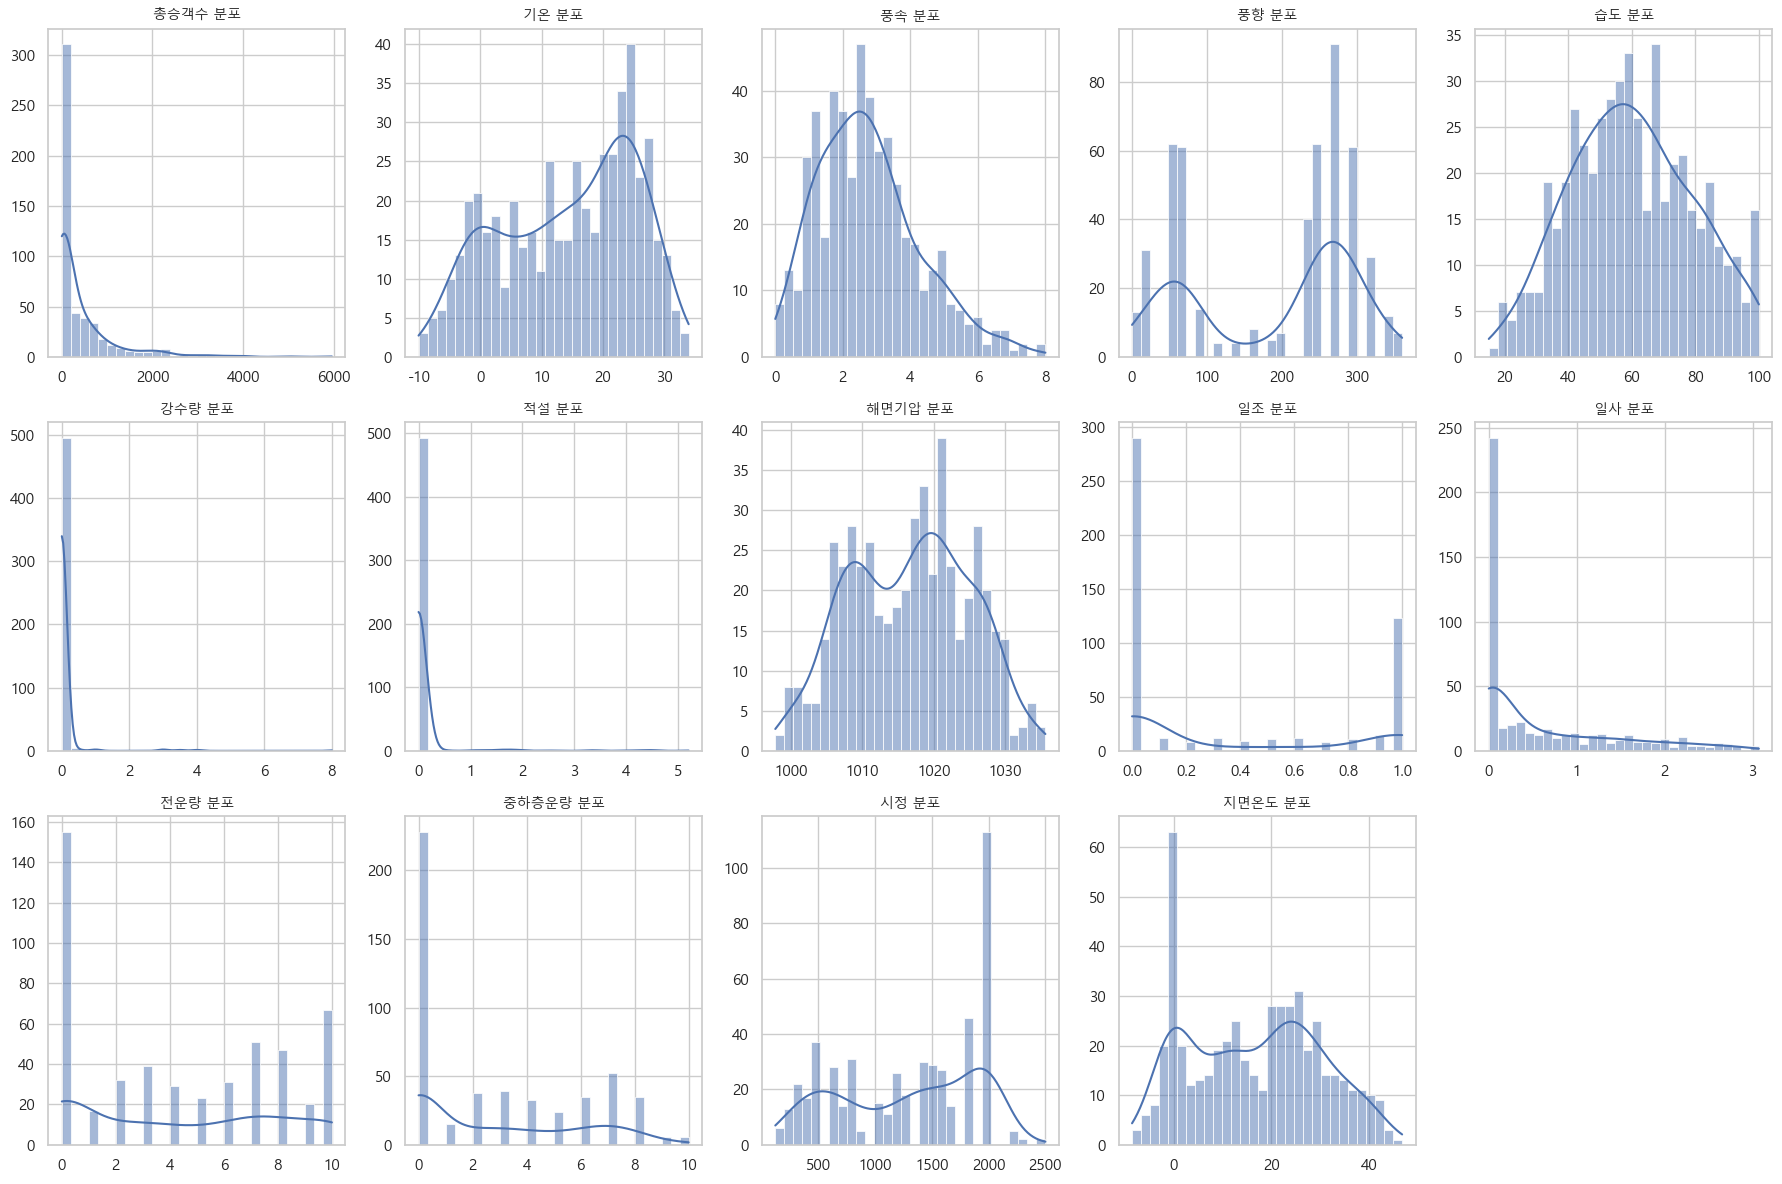

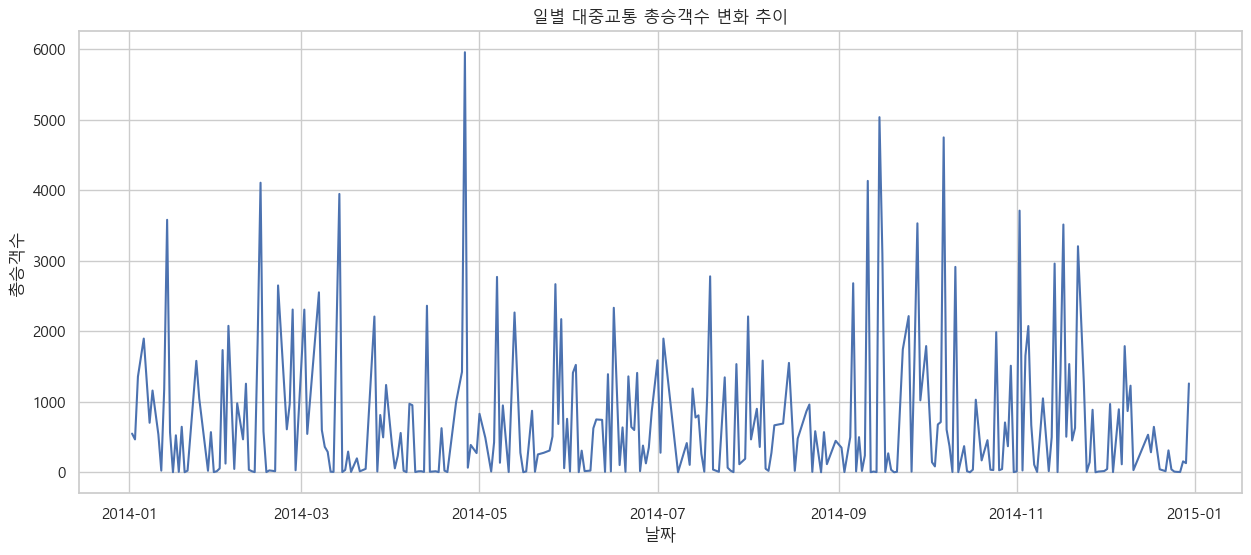

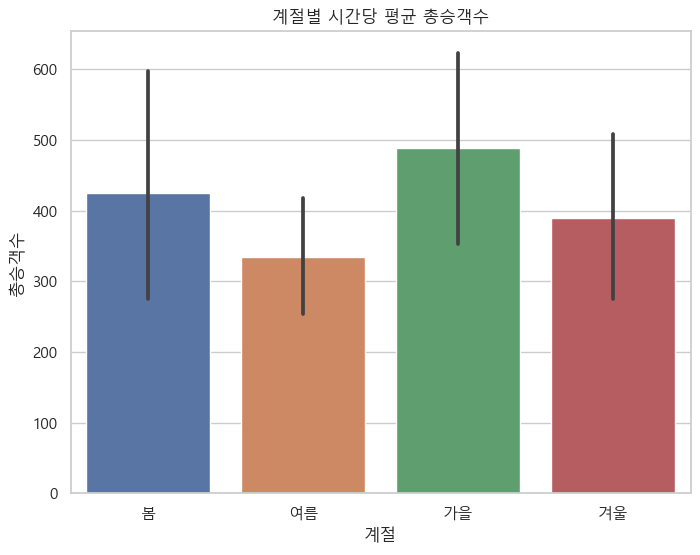

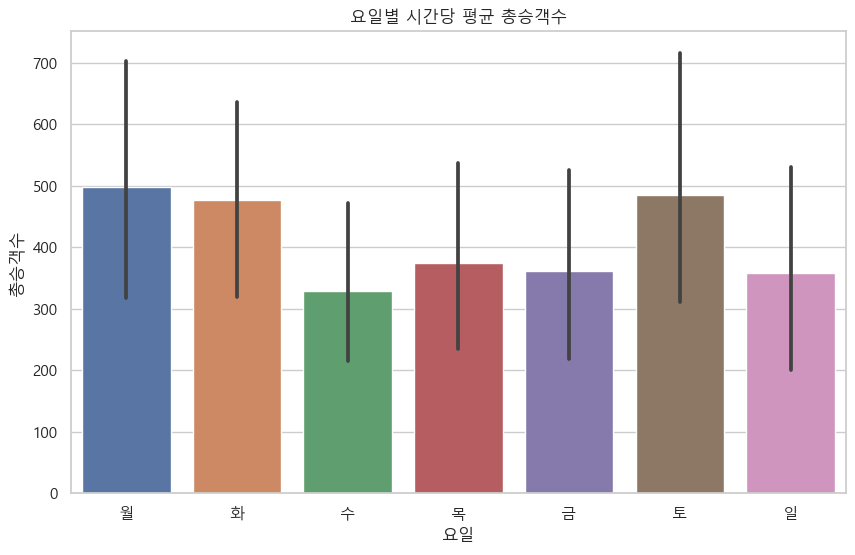

c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


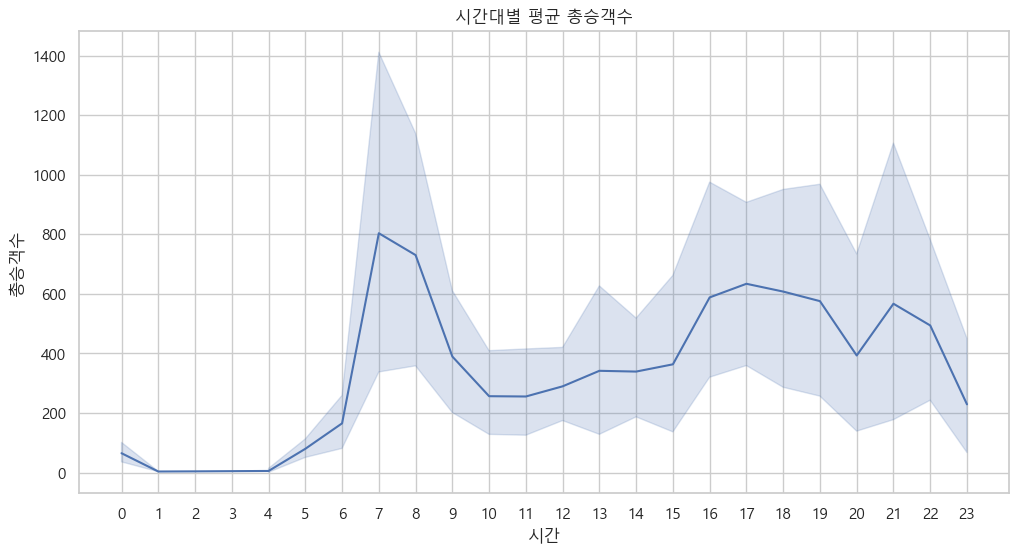

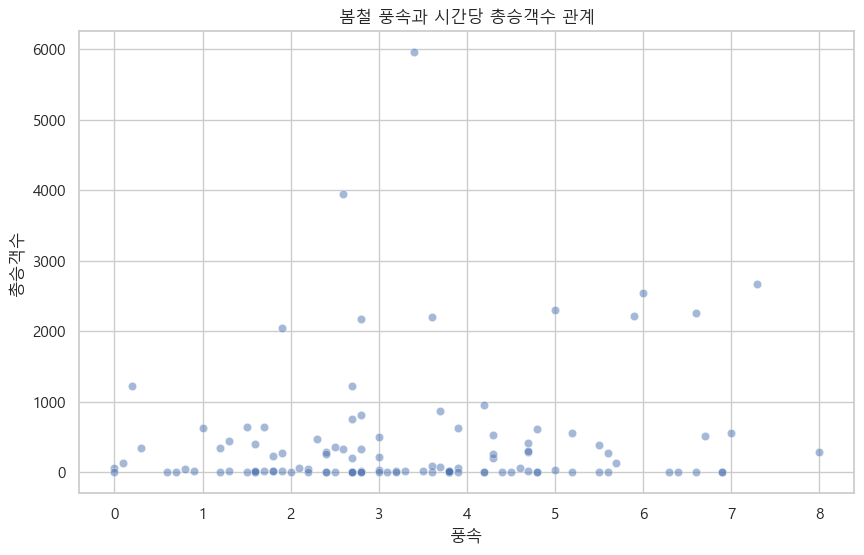

In [6]:
# # 5. EDA (탐색적 데이터 분석)

if not final_df.empty:
    print("\n--- EDA 시작 ---")
    
# Cell 16의 plot_cols 부분 수정

    # ... (EDA 시작 코드 이후) ...
    # 5.1. 총승객수 및 주요 기상 변수 분포 확인
    plt.figure(figsize=(18, 12)) # 그림 크기 조정
    # 포함하고 싶은 모든 숫자형 기상 변수 추가
    plot_cols = ['총승객수', '기온', '풍속', '풍향', '습도', '강수량', '적설', 
                 '해면기압', '일조', '일사', '전운량', '중하층운량', '시정', '지면온도']
    
    existing_plot_cols = [col for col in plot_cols if col in final_df.columns and pd.api.types.is_numeric_dtype(final_df[col])]
    
    num_plots = len(existing_plot_cols)
    # subplot 행/열 개수 동적 계산 (최대 5열로 가정)
    cols_per_row = 5
    rows_for_plot = (num_plots + cols_per_row - 1) // cols_per_row

    for i, col in enumerate(existing_plot_cols):
        plt.subplot(rows_for_plot, cols_per_row, i + 1)
        sns.histplot(final_df[col].dropna(), kde=True, bins=30) # dropna() 추가
        plt.title(f'{col} 분포', fontsize=10)
        plt.xlabel('') # x축 레이블 간소화
        plt.ylabel('') # y축 레이블 간소화
    plt.tight_layout()
    plt.show()
# ... (나머지 EDA 코드는 기존 활용 가능, 필요시 추가 변수에 대한 시각화 추가) ...

    # 5.2. 시간에 따른 총승객수 변화 (일별)
    # 일별 총 승객수로 집계하여 시각화 (너무 많으면 일부 기간만)
    daily_passengers = final_df.groupby(final_df['날짜'].dt.date)['총승객수'].sum()
    plt.figure(figsize=(15, 6))
    daily_passengers.plot()
    plt.title('일별 대중교통 총승객수 변화 추이')
    plt.xlabel('날짜')
    plt.ylabel('총승객수')
    plt.show()

    # 5.3. 계절별 평균 총승객수
    plt.figure(figsize=(8, 6))
    sns.barplot(x='계절', y='총승객수', data=final_df, estimator=np.mean, order=['봄', '여름', '가을', '겨울'])
    plt.title('계절별 시간당 평균 총승객수')
    plt.show()

    # 5.4. 요일별 평균 총승객수
    plt.figure(figsize=(10, 6))
    sns.barplot(x='요일', y='총승객수', data=final_df, estimator=np.mean, order=['월','화','수','목','금','토','일'])
    plt.title('요일별 시간당 평균 총승객수')
    plt.show()

    # 5.5. 시간대별 평균 총승객수
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='시간', y='총승객수', data=final_df, estimator=np.mean)
    plt.title('시간대별 평균 총승객수')
    plt.xticks(range(0,24))
    plt.grid(True)
    plt.show()
    
    # 5.6. 봄철 풍속과 총승객수 산점도
    spring_df = final_df[final_df['계절'] == '봄']
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='풍속', y='총승객수', data=spring_df, alpha=0.5)
    plt.title('봄철 풍속과 시간당 총승객수 관계')
    plt.show()
    
else:
    print("분석할 데이터가 없어 EDA를 건너뜁니다.")


--- 통계 분석 시작 ---

--- T-검정: 출퇴근 시간 vs 비출퇴근 시간 기상 데이터 차이 ---
    계절     변수  T-statistic       p-value
0    봄     기온    -2.599638  1.088931e-02
1    봄    강수량     0.157420  8.752015e-01
2    봄     풍속    -1.824972  7.088086e-02
3    봄     풍향    -1.144970  2.556308e-01
4    봄     습도     3.103008  2.506315e-03
5    봄     적설     1.000000  3.227785e-01
6    봄   해면기압     0.846780  3.991776e-01
7    봄     일조    -3.617806  4.580222e-04
8    봄     일사    -7.662380  1.650820e-11
9    봄    전운량     0.210133  8.340352e-01
10   봄  중하층운량     0.379199  7.055742e-01
11   봄     시정    -0.151258  8.800986e-01
12   봄   지면온도    -5.803024  6.262954e-08
13  여름     기온    -2.647703  9.348562e-03
14  여름    강수량     0.863036  3.912680e-01
15  여름     풍속    -0.442726  6.588545e-01
16  여름     풍향    -1.430941  1.558031e-01
17  여름     습도     2.533458  1.264321e-02
18  여름     적설          NaN           NaN
19  여름   해면기압    -0.764793  4.460856e-01
20  여름     일조    -0.866445  3.883533e-01
21  여름     일사    -3.299998  1.252080e

c:\Users\USER\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


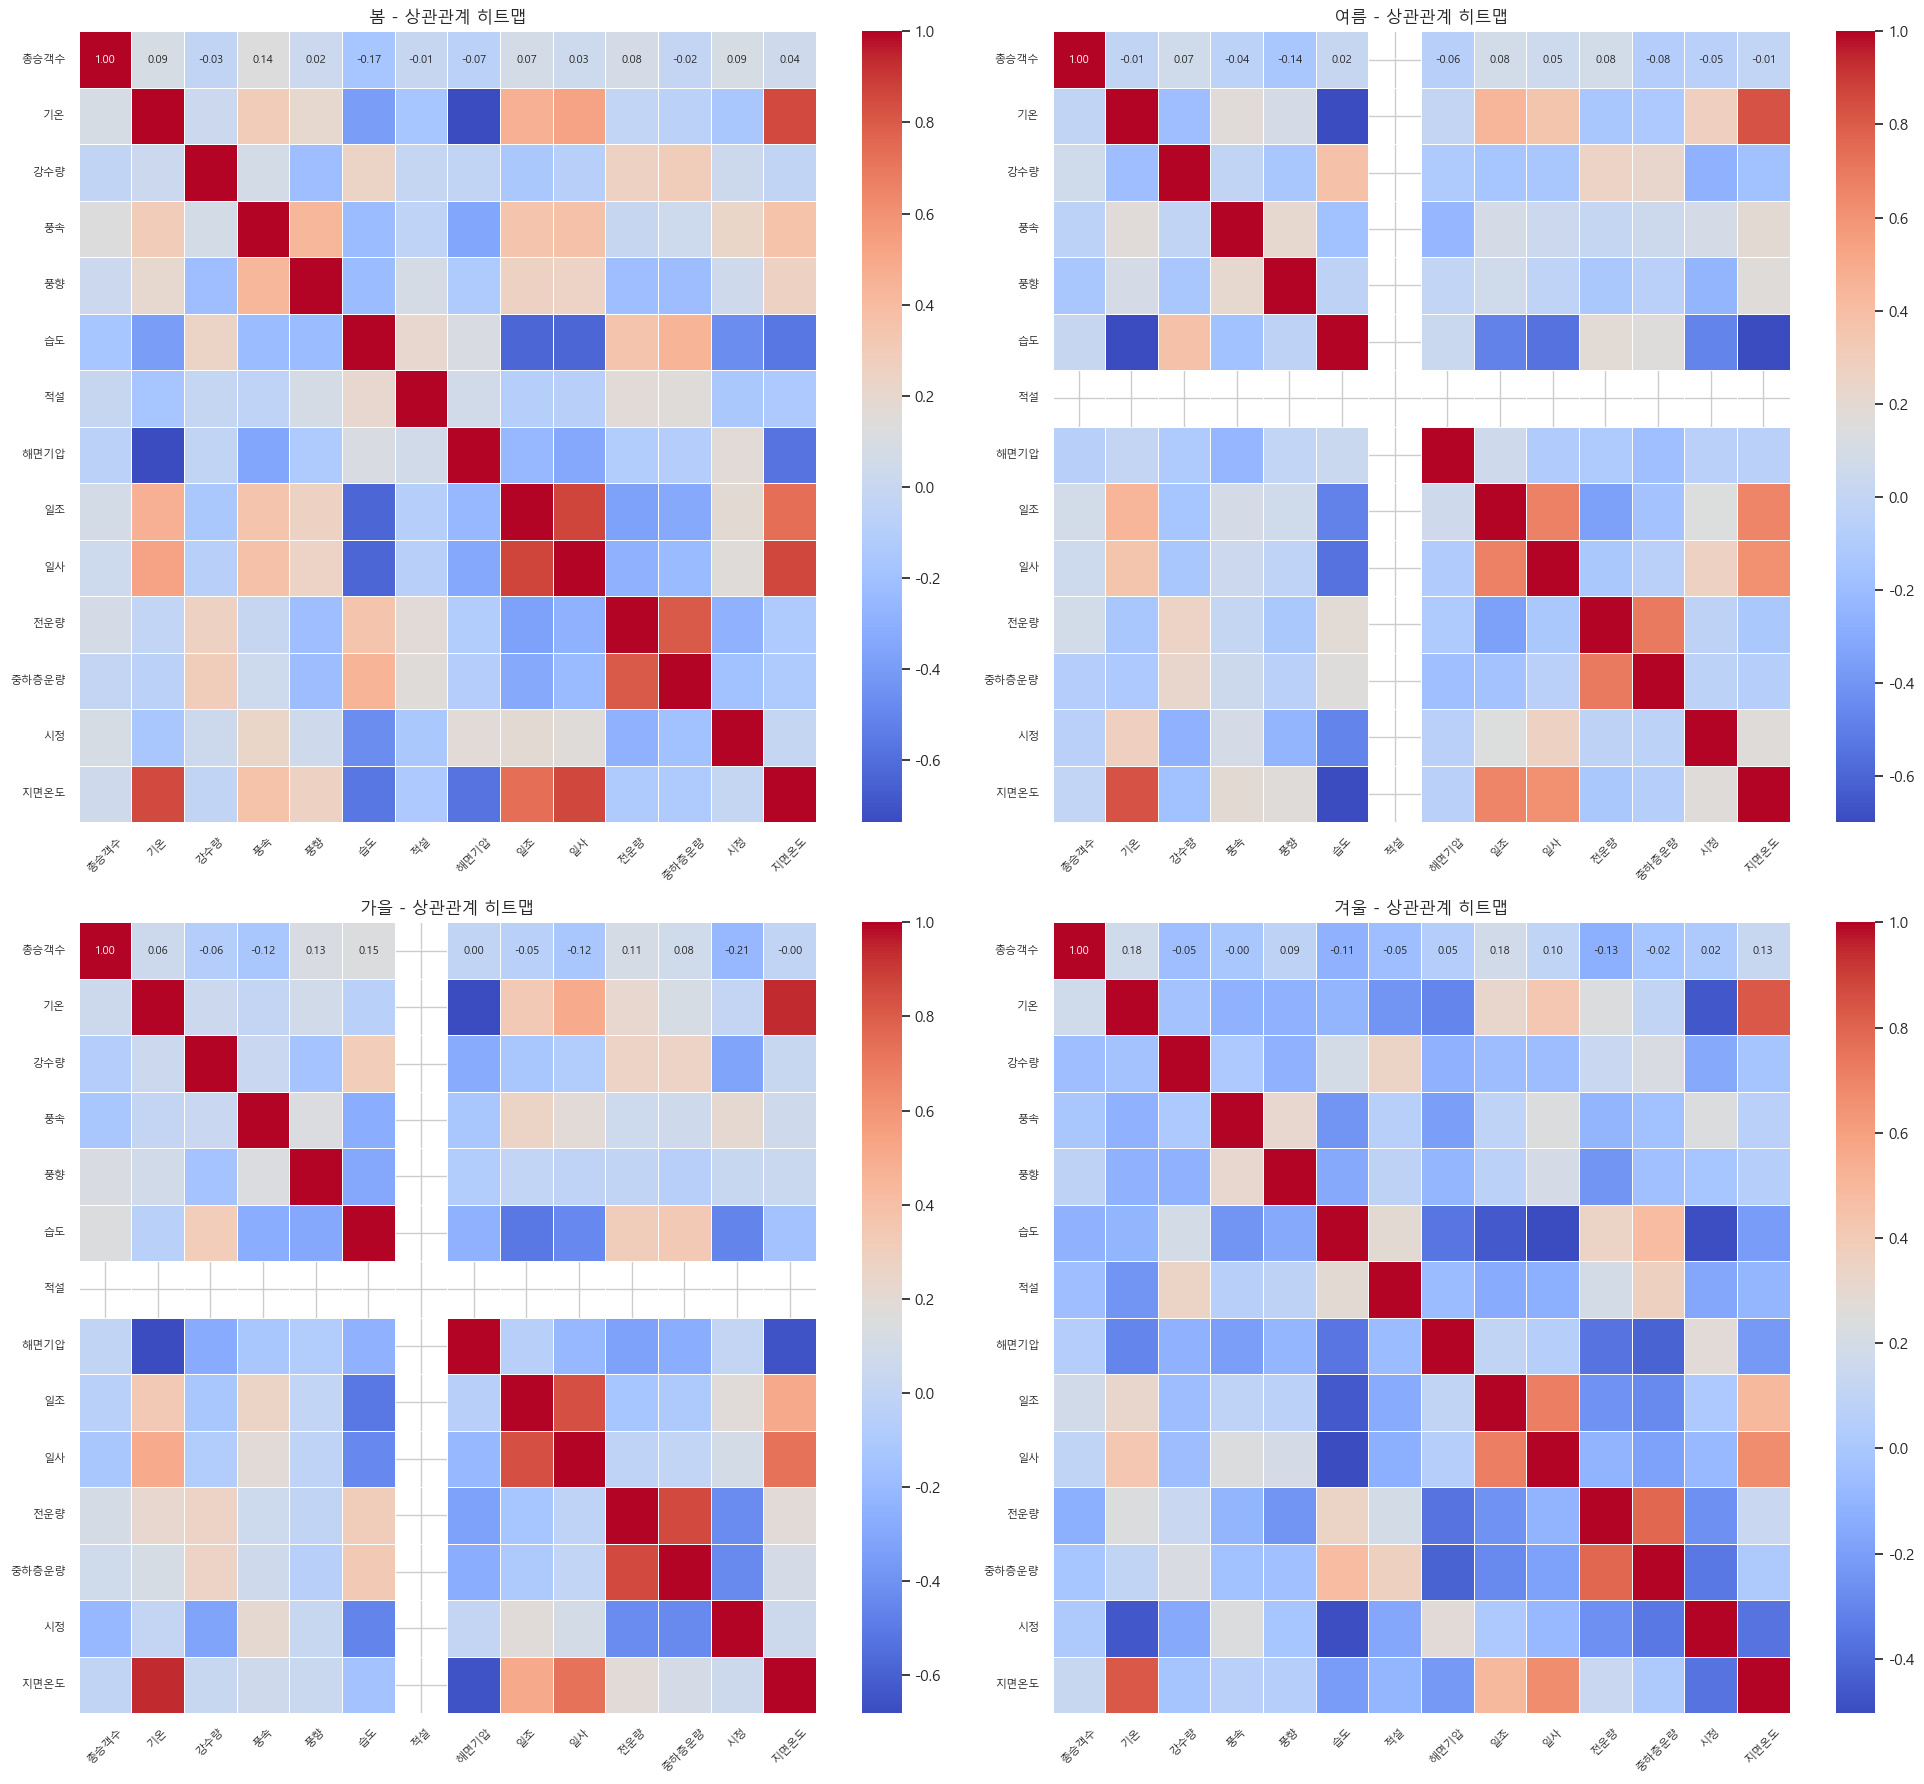


--- 상관계수 및 p-value 결과 ---
    계절     변수      상관계수   p-value
0    봄     기온  0.087959  0.354231
1    봄    강수량 -0.032664  0.731258
2    봄     풍속  0.135657  0.151957
3    봄     풍향  0.017815  0.851438
4    봄     습도 -0.167606  0.075991
5    봄     적설 -0.007117  0.940361
6    봄   해면기압 -0.067946  0.474567
7    봄     일조  0.065971  0.487531
8    봄     일사  0.032273  0.734353
9    봄    전운량  0.077884  0.412237
10   봄  중하층운량 -0.021621  0.820187
11   봄     시정  0.089576  0.345417
12   봄   지면온도  0.037641  0.692238
13  여름     기온 -0.012444  0.887385
14  여름    강수량  0.066079  0.451577
15  여름     풍속 -0.038233  0.663381
16  여름     풍향 -0.138320  0.113723
17  여름     습도  0.015134  0.863254
18  여름     적설       NaN       NaN
19  여름   해면기압 -0.062209  0.478560
20  여름     일조  0.081169  0.354850
21  여름     일사  0.054165  0.537336
22  여름    전운량  0.079524  0.364722
23  여름  중하층운량 -0.076220  0.385043
24  여름     시정 -0.051320  0.558954
25  여름   지면온도 -0.006520  0.940851
26  가을     기온  0.059052  0.475891
27  가을    강수량 -0.0637

In [7]:
# # 6. 통계 분석

# 이전에 생성된 final_df (병합 및 전처리 완료된 데이터프레임)를 사용한다고 가정합니다.
if not final_df.empty and len(final_df) > 0:
    print("\n--- 통계 분석 시작 ---")

    # ## 6.1. T-검정 (출퇴근 시간 vs 비출퇴근 시간 기상 데이터 차이)
    print("\n--- T-검정: 출퇴근 시간 vs 비출퇴근 시간 기상 데이터 차이 ---")
    ttest_results_list = []
    
    # T-검정에 사용할 확장된 날씨 변수 목록
    weather_vars_for_ttest = [
        '기온', '강수량', '풍속', '풍향', '습도', '적설', 
        '해면기압', '일조', '일사', '전운량', '중하층운량', '시정', '지면온도'
    ]
    # final_df에 실제로 존재하는 컬럼만으로 필터링
    weather_vars_for_ttest = [col for col in weather_vars_for_ttest if col in final_df.columns]
    
    for season in ['봄', '여름', '가을', '겨울']:
        season_data = final_df[final_df['계절'] == season]
        if season_data.empty or len(season_data) < 20: # 최소 샘플 수
            print(f"{season} 데이터가 부족하여 T-검정을 건너뜁니다.")
            for var_name in weather_vars_for_ttest:
                 ttest_results_list.append({'계절': season, '변수': var_name, 'T-statistic': np.nan, 'p-value': np.nan})
            continue
        
        commute_data = season_data[season_data['출퇴근구분'] == '출퇴근시간']
        non_commute_data = season_data[season_data['출퇴근구분'] == '비출퇴근시간']
        
        for var in weather_vars_for_ttest:
            if var not in season_data.columns:
                stat, p_val = np.nan, np.nan
            elif commute_data[var].dropna().empty or non_commute_data[var].dropna().empty or \
                 len(commute_data[var].dropna()) < 2 or len(non_commute_data[var].dropna()) < 2:
                stat, p_val = np.nan, np.nan
            else:
                stat, p_val = ttest_ind(commute_data[var].dropna(), non_commute_data[var].dropna(), equal_var=False, nan_policy='omit')
            ttest_results_list.append({'계절': season, '변수': var, 'T-statistic': stat, 'p-value': p_val})

    ttest_df = pd.DataFrame(ttest_results_list)
    if not ttest_df.empty:
        print(ttest_df.to_string()) # 모든 행이 출력되도록 to_string() 사용
    else:
        print("T-검정 결과를 생성할 수 없습니다.")
    print("\n* 해석: p-value가 0.05보다 크면 출퇴근 시간과 비출퇴근 시간 간에 해당 기상 변수의 평균값에 통계적으로 유의미한 차이가 없다고 볼 수 있습니다.")


    # ## 6.2. 계절별 상관 분석 (Pearson)
    print("\n--- 계절별 상관 분석 (총승객수 vs 기상변수) ---")
    correlation_results_list = []
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 18)) # 히트맵 크기 조정
    axes = axes.flatten() 
    
    seasons = ['봄', '여름', '가을', '겨울']
    # 상관분석에 사용할 확장된 날씨 변수 목록
    weather_vars_for_corr = [
        '기온', '강수량', '풍속', '풍향', '습도', '적설', 
        '해면기압', '일조', '일사', '전운량', '중하층운량', '시정', '지면온도'
    ]
    # final_df에 실제로 존재하는 컬럼만으로 필터링
    weather_vars_for_corr = [col for col in weather_vars_for_corr if col in final_df.columns]
        
    for i, season in enumerate(seasons):
        ax = axes[i]
        season_data = final_df[final_df['계절'] == season]
        
        # 히트맵을 위한 컬럼 (총승객수 + 실제 존재하는 날씨 변수)
        analysis_cols_for_heatmap = ['총승객수'] + [col for col in weather_vars_for_corr if col in season_data.columns]

        if season_data.empty or len(season_data) < 20 or '총승객수' not in season_data.columns or len(analysis_cols_for_heatmap) < 2:
            print(f"{season} 데이터가 부족하거나 '총승객수' 또는 분석할 날씨 컬럼이 없어 상관분석 히트맵을 건너뜁니다.")
            ax.set_title(f'{season} - 데이터 부족')
            ax.axis('off')
            for var_name in weather_vars_for_corr: # 결과 테이블용 placeholder
                correlation_results_list.append({'계절': season, '변수': var_name, '상관계수': np.nan, 'p-value': np.nan})
            continue

        season_corr = season_data[analysis_cols_for_heatmap].corr(method='pearson')
        
        sns.heatmap(season_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax, annot_kws={"size": 8}) # annot 글자 크기 조정
        ax.set_title(f'{season} - 상관관계 히트맵', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=8) # x축 레이블 회전 및 크기 조정
        ax.tick_params(axis='y', labelsize=8) # y축 레이블 크기 조정


        for var in weather_vars_for_corr: # 개별 상관계수 계산용
            if var not in season_data.columns or season_data[var].isnull().all() or \
               season_data['총승객수'].isnull().all() or len(season_data[[var, '총승객수']].dropna()) < 2:
                 corr, p_val = np.nan, np.nan
            else:
                clean_pair = season_data[[var, '총승객수']].dropna()
                corr, p_val = pearsonr(clean_pair[var], clean_pair['총승객수'])
            correlation_results_list.append({'계절': season, '변수': var, '상관계수': corr, 'p-value': p_val})
            
    plt.tight_layout()
    plt.show()

    correlation_df = pd.DataFrame(correlation_results_list)
    if not correlation_df.empty:
        print("\n--- 상관계수 및 p-value 결과 ---")
        print(correlation_df.to_string()) # 모든 행이 출력되도록 to_string() 사용
    else:
        print("상관계수 결과를 생성할 수 없습니다.")
    print("\n* 해석: p-value가 0.05보다 작을 때 상관계수가 통계적으로 유의미하다고 판단합니다.")



--- '출퇴근 여부'가 '총승객수'에 미치는 영향에 대한 계절별 회귀분석 ---

--- 가을: passengers ~ C(commute_status) (단순 선형 회귀) ---
                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.520
Date:                Fri, 09 May 2025   Prob (F-statistic):             0.0117
Time:                        16:26:45   Log-Likelihood:                -1209.7
No. Observations:                 148   AIC:                             2423.
Df Residuals:                     146   BIC:                             2429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

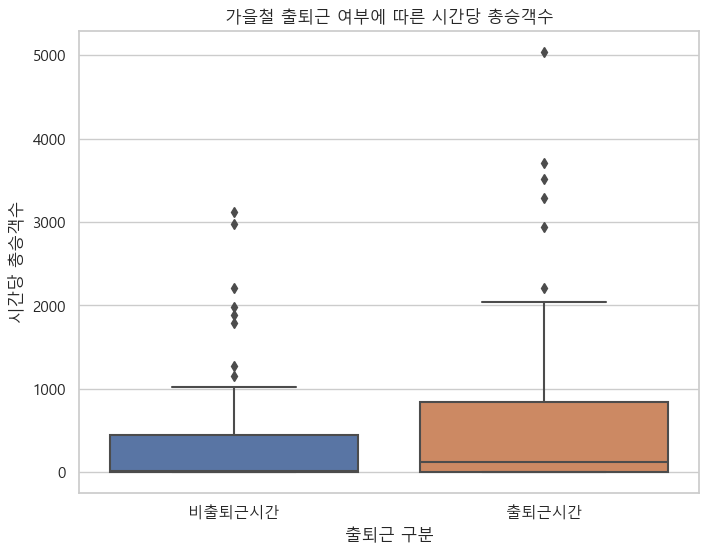

In [8]:
# ## 6.3.2. T-검정에서 유의미한 차이를 보인 '출퇴근 여부'에 대한 계절별 단순 선형 회귀분석
# ### (예: 가을철 출퇴근 여부가 총승객수에 미치는 영향)

if 'final_df' not in globals() or final_df.empty:
    print("분석할 최종 데이터(final_df)가 준비되지 않았습니다. 이전 단계를 먼저 실행해주세요.")
else:
    print("\n--- '출퇴근 여부'가 '총승객수'에 미치는 영향에 대한 계절별 회귀분석 ---")

    # 분석 대상 계절 (T-검정에서 '총승객수' 차이가 유의미했던 계절)
    target_season_for_commute_effect = '가을' 
    
    # 해당 계절 데이터 필터링
    season_data_commute_reg = final_df[final_df['계절'] == target_season_for_commute_effect].copy()

    if season_data_commute_reg.empty:
        print(f"{target_season_for_commute_effect}철 데이터가 없어 회귀분석을 건너뜁니다.")
    elif '총승객수' not in season_data_commute_reg.columns or '출퇴근구분' not in season_data_commute_reg.columns:
        print(f"{target_season_for_commute_effect}철 데이터에 '총승객수' 또는 '출퇴근구분' 컬럼이 없어 회귀분석을 건너뜁니다.")
    elif len(season_data_commute_reg.dropna(subset=['총승객수', '출퇴근구분'])) < 20: # 최소 샘플 수
        print(f"{target_season_for_commute_effect}철 데이터가 부족하여 회귀분석을 건너뜁니다.")
    else:
        # '출퇴근구분'을 더미 변수(0 또는 1)로 변환 (예: '비출퇴근시간' = 0, '출퇴근시간' = 1)
        # statsmodels의 C()를 사용하면 자동으로 더미 변수화 되므로, 여기서는 컬럼명만 영어로 변경
        season_data_commute_reg.rename(columns={
            '총승객수': 'passengers',
            '출퇴근구분': 'commute_status' # formula에서 C(commute_status)로 사용
        }, inplace=True)

        print(f"\n--- {target_season_for_commute_effect}: passengers ~ C(commute_status) (단순 선형 회귀) ---")
        try:
            # C(commute_status)는 commute_status를 범주형 변수로 처리하라는 의미
            # 비출퇴근시간이 보통 알파벳 순서상 먼저 오므로 기준(0)이 되고, 출퇴근시간이 비교대상(1)이 됨
            formula = 'passengers ~ C(commute_status)'
            model_commute_effect = smf.ols(formula=formula, data=season_data_commute_reg).fit()
            print(model_commute_effect.summary())
            
            # 회귀계수 및 관련 통계량 추출
            # statsmodels는 C(범주형변수)[T.카테고리명] 형태로 계수 이름을 만듭니다.
            # 예를 들어 'commute_status'의 값이 '출퇴근시간', '비출퇴근시간'이고 '비출퇴근시간'이 기준이면,
            # 계수 이름은 'C(commute_status)[T.출퇴근시간]'이 됩니다.
            
            # 실제 더미 변수화된 컬럼 이름 찾기 (기준이 아닌 카테고리)
            dummy_col_name = [col for col in model_commute_effect.params.index if 'C(commute_status)[T.' in col]
            
            if dummy_col_name:
                coef_commute = model_commute_effect.params[dummy_col_name[0]]
                p_val_coef_commute = model_commute_effect.pvalues[dummy_col_name[0]]
                base_category = "비출퇴근시간" # (commute_status의 값 중 알파벳 순으로 빠른 것이 보통 기준이 됨)
                comparison_category = dummy_col_name[0].split("T.")[1][:-1] # 예: '출퇴근시간'
                
                print(f"\n* 해석 ({target_season_for_commute_effect} - 출퇴근 여부):")
                print(f"  '{base_category}' 대비 '{comparison_category}'일 때,")
                print(f"  시간당 평균 총승객수는 약 {coef_commute:.2f}명 더 많거나 적습니다(변화합니다).")
                print(f"  이 차이의 통계적 유의성 (p-value): {p_val_coef_commute:.4f}")
                print(f"  모델 설명력 (R-squared): {model_commute_effect.rsquared:.3f}")
                if p_val_coef_commute >= 0.05:
                    print(f"  주의: '출퇴근 여부' 변수의 p-value가 0.05 이상이므로, 이 회귀계수는 통계적으로 유의미하다고 보기 어렵습니다.")
                else: # p-value < 0.05 인 경우
                    if coef_commute > 0:
                        print(f"  즉, {target_season_for_commute_effect}철에는 비출퇴근 시간보다 출퇴근 시간에 시간당 평균 약 {coef_commute:.2f}명의 승객이 더 많습니다.")
                    else:
                        print(f"  즉, {target_season_for_commute_effect}철에는 비출퇴근 시간보다 출퇴근 시간에 시간당 평균 약 {abs(coef_commute):.2f}명의 승객이 더 적습니다.")

                # 시각화 (Boxplot 또는 Barplot이 더 적절할 수 있음)
                plt.figure(figsize=(8,6))
                sns.boxplot(x='commute_status', y='passengers', data=season_data_commute_reg, order=['비출퇴근시간', '출퇴근시간'])
                # sns.barplot(x='commute_status', y='passengers', data=season_data_commute_reg, estimator=np.mean, order=['비출퇴근시간', '출퇴근시간'])
                plt.title(f'{target_season_for_commute_effect}철 출퇴근 여부에 따른 시간당 총승객수')
                plt.xlabel('출퇴근 구분')
                plt.ylabel('시간당 총승객수')
                plt.show()
            else:
                print("회귀분석 결과에서 '출퇴근 여부' 관련 계수를 찾을 수 없습니다. commute_status 컬럼의 값을 확인해주세요.")
                
        except Exception as e:
            print(f"{target_season_for_commute_effect}철 '출퇴근 여부' 회귀 분석 중 오류 발생: {e}")
            print("  'commute_status' 컬럼의 고유값(unique values)과 데이터 타입을 확인해주세요. (예: '출퇴근시간', '비출퇴근시간')")


--- 유의미한 상관관계를 보인 변수에 대한 계절별 단순 선형 회귀분석 ---

--- 가을: passengers ~ visibility (단순 선형 회귀) ---
                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     6.705
Date:                Fri, 09 May 2025   Prob (F-statistic):             0.0106
Time:                        16:26:45   Log-Likelihood:                -1209.6
No. Observations:                 148   AIC:                             2423.
Df Residuals:                     146   BIC:                             2429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

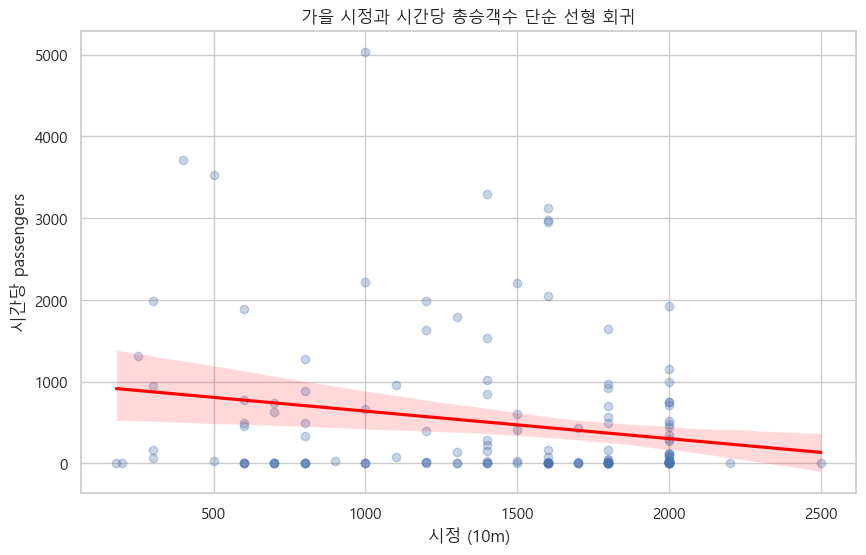


--- 겨울: passengers ~ sunshine_hours (단순 선형 회귀) ---
                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.925
Date:                Fri, 09 May 2025   Prob (F-statistic):             0.0499
Time:                        16:26:46   Log-Likelihood:                -934.22
No. Observations:                 118   AIC:                             1872.
Df Residuals:                     116   BIC:                             1878.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

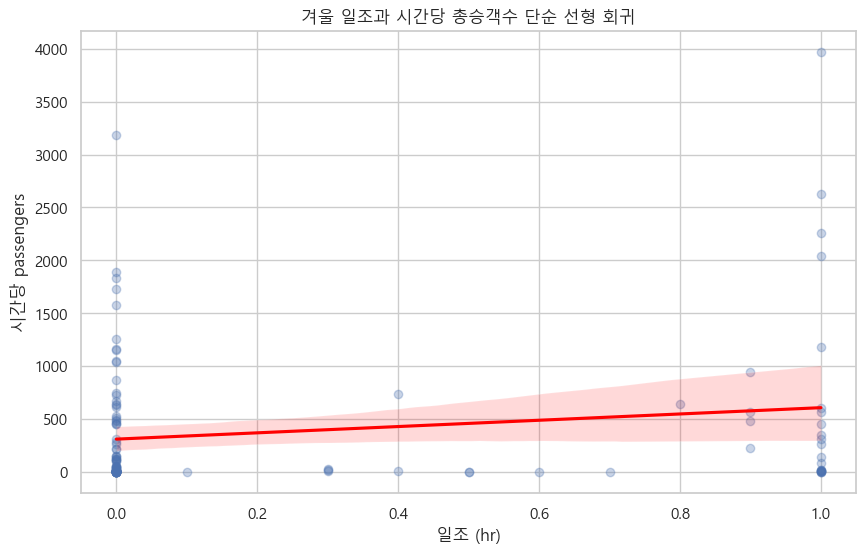

In [9]:

# ## 6.3.1. 유의미한 상관관계를 보인 변수에 대한 계절별 단순 선형 회귀분석

# 이전에 생성된 final_df 와 correlation_df (상관계수 및 p-value 테이블)가 있다고 가정합니다.
# correlation_df는 '계절', '변수', '상관계수', 'p-value' 컬럼을 가져야 합니다.

if 'final_df' not in globals() or final_df.empty:
    print("분석할 최종 데이터(final_df)가 준비되지 않았습니다. 이전 단계를 먼저 실행해주세요.")
elif 'correlation_df' not in globals() or correlation_df.empty:
    print("상관분석 결과(correlation_df)가 없습니다. 상관분석을 먼저 실행해주세요.")
else:
    print("\n--- 유의미한 상관관계를 보인 변수에 대한 계절별 단순 선형 회귀분석 ---")

    # 분석 대상: (계절, 한글 변수명)
    significant_pairs_to_analyze = [
        ('가을', '시정'),  # 가을철 시정
        ('겨울', '일조')   # 겨울철 일조
    ]

    # 영어 변수명 매핑 (statsmodels formula 및 컬럼 접근용)
    var_map_eng = {
        '총승객수': 'passengers', '풍속': 'wind_speed', '기온': 'temp',
        '습도': 'humidity', '강수량': 'precipitation', '적설': 'snowfall',
        '요일코드': 'day_of_week_code', '시간': 'hour',
        '풍향': 'wind_direction', '해면기압': 'sea_pressure', '일조': 'sunshine_hours',
        '일사': 'solar_radiation', '전운량': 'total_cloud_cover',
        '중하층운량': 'midlow_cloud_cover', '시정': 'visibility', '지면온도': 'surface_temp'
    }

    for season, weather_var_kor in significant_pairs_to_analyze:
        # 해당 계절 데이터 필터링
        season_data_reg = final_df[final_df['계절'] == season].copy()

        # 분석에 사용할 영어 변수명 가져오기
        dependent_var_eng = var_map_eng.get('총승객수')
        independent_var_eng = var_map_eng.get(weather_var_kor)

        if dependent_var_eng is None or independent_var_eng is None:
            print(f"경고: '{weather_var_kor}' 또는 '총승객수'에 대한 영어 변수명 매핑이 없습니다. 건너뜁니다.")
            continue
        
        # 컬럼명 변경 (statsmodels formula를 위해)
        # 필요한 컬럼만 선택적으로 rename
        cols_to_rename_simple_reg = {
            '총승객수': dependent_var_eng,
            weather_var_kor: independent_var_eng
        }
        # season_data_reg에 실제로 존재하는 컬럼만 rename
        actual_cols_to_rename = {k: v for k, v in cols_to_rename_simple_reg.items() if k in season_data_reg.columns}
        season_data_reg.rename(columns=actual_cols_to_rename, inplace=True)
        
        # 필요한 컬럼 존재 및 데이터 충분 여부 확인
        if dependent_var_eng not in season_data_reg.columns or \
           independent_var_eng not in season_data_reg.columns or \
           len(season_data_reg.dropna(subset=[dependent_var_eng, independent_var_eng])) < 20: # 최소 샘플 수
            print(f"\n--- {season} - '{weather_var_kor}' 변수 ---")
            print(f"데이터가 부족하거나 필요한 컬럼 ('{dependent_var_eng}', '{independent_var_eng}')이 없어 회귀분석을 건너뜁니다.")
            continue

        print(f"\n--- {season}: {dependent_var_eng} ~ {independent_var_eng} (단순 선형 회귀) ---")
        try:
            formula = f'{dependent_var_eng} ~ {independent_var_eng}'
            model = smf.ols(formula=formula, data=season_data_reg).fit()
            print(model.summary())
            
            # 회귀계수 및 관련 통계량 추출
            coef = model.params.get(independent_var_eng, np.nan)
            p_val_coef = model.pvalues.get(independent_var_eng, np.nan)
            r_squared = model.rsquared
            
            # 단위 정보 가져오기 (예시, 실제 단위는 데이터 설명 참조)
            units = {'시정': '10m', '일조': 'hr'} # 필요시 다른 변수 단위 추가
            unit_str = f"({units.get(weather_var_kor, '')})" if units.get(weather_var_kor) else ""

            print(f"\n* 해석 ({season} - {weather_var_kor}):")
            print(f"  {weather_var_kor}{unit_str}이(가) 1단위 증가할 때, 시간당 {dependent_var_eng}(총승객수)는 약 {coef:.2f}명 변화(증가 또는 감소)하는 것으로 나타납니다.")
            print(f"  이 관계의 통계적 유의성 (p-value): {p_val_coef:.4f}")
            print(f"  모델 설명력 (R-squared): {r_squared:.3f}")
            if p_val_coef >= 0.05:
                print(f"  주의: {weather_var_kor} 변수의 p-value가 0.05 이상이므로, 이 회귀계수는 통계적으로 유의미하다고 보기 어렵습니다.")


            # 시각화
            plt.figure(figsize=(10,6))
            sns.regplot(x=independent_var_eng, y=dependent_var_eng, data=season_data_reg, 
                        scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
            plt.title(f'{season} {weather_var_kor}과 시간당 총승객수 단순 선형 회귀')
            plt.xlabel(f'{weather_var_kor} {unit_str}')
            plt.ylabel(f'시간당 {dependent_var_eng}')
            plt.show()
            
        except Exception as e:
            print(f"{season} - '{weather_var_kor}' 변수 회귀 분석 중 오류 발생: {e}")